In [2]:
import numpy as np
from skimage import measure as ms
import matplotlib.pyplot as plt
import time 
import scipy.ndimage as sn
from IPython.core.display import display, HTML
import sys
sys.path.append('C:/Users/hyli93/Documents/GitHub/Phasing/')

display(HTML("<style>.container { width:95% !important; }</style>"))
import phase
import phase.cpualgorithms

# Load pattern

The image size is 327 by 300


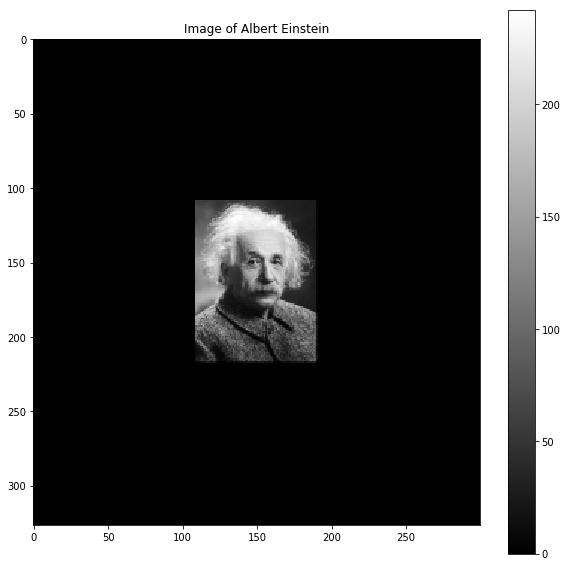

In [3]:
############################################################################################################################################
# Load the pattern
############################################################################################################################################
#Read in source image
source = plt.imread("../tests/samples/Albert_Einstein.jpg",format="jpg")

# Because the original image is too large downsample the image by a factor of 20
source = ms.block_reduce(source, (40,40), np.mean)

############################################################################################################################################
# Simulate the oversampling
############################################################################################################################################
## pad_len is the size of the support
pad_len = source.shape[0]
padded = np.pad(source, ((pad_len, pad_len),(pad_len, pad_len)), 'constant', 
                constant_values=((0,0),(0,0)))

#Show this figure
fig = plt.figure(figsize=(10,10))
plt.imshow(padded, cmap="gray")
plt.colorbar()
plt.title("Image of Albert Einstein")
print("The image size is %d by %d"%(padded.shape[0], padded.shape[1]))

# Get Diffraction intensity and the mask

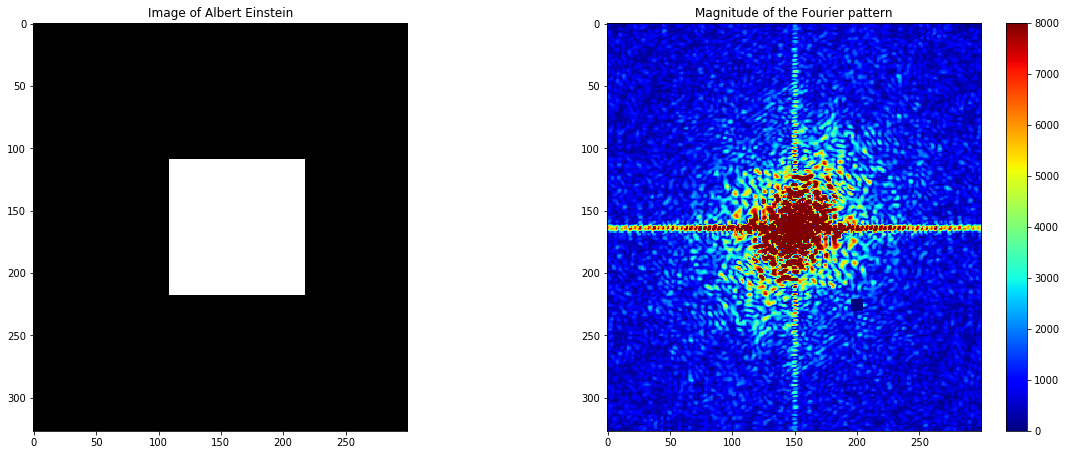

The image size is 327 by 300


In [13]:
# Calculate the fourier transformation
fourier_pattern = np.fft.ifftshift(np.fft.fft2(padded))

#simulate diffraction pattern
intensity = np.square(np.abs(fourier_pattern))

#keep track of where the image is vs the padding
length, width = padded.shape
#keep track of where the image is vs the padding
mask_float = np.zeros_like(padded, dtype=np.int64)
mask_float[pad_len:2*pad_len, pad_len:2*pad_len] = 1

mask_bool = np.zeros_like(mask_float)
mask_bool[mask_float>=0.5] = True

# Add beam stop effect
r_stop = 5  # Radius of the beam stop
fourier_pattern[226 - r_stop: 226 + r_stop, 200 - r_stop: 200 + r_stop] = 0

# Get mask in reciprocal space with boolean values
reciprocal_mask_bool = np.ones_like(fourier_pattern, dtype=np.bool)
reciprocal_mask_bool[:,:] = True
reciprocal_mask_bool[226 - r_stop: 226 + r_stop, 200 - r_stop: 200 + r_stop] = False

#Show this mask and the diffraction magnitude
magnitude = np.abs(fourier_pattern)

fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(20)
fig.set_figheight(7.5)

axes[0].imshow(mask_float, cmap='gray')
axes[0].set_title("Image of Albert Einstein")

tmp = axes[1].imshow(magnitude, cmap='jet', vmax=8e3)
axes[1].set_title("Magnitude of the Fourier pattern")

fig.colorbar(mappable=tmp, ax=axes[1])

plt.show()
print("The image size is %d by %d"%(mask_bool.shape[0], mask_bool.shape[1]))

# Begin the calculation

In [32]:
result = phase.cpualgorithms.apply_hio_with_wrap_shrink(magnitude_constrain= np.fft.fftshift(magnitude),
                                                        support_bool = np.fft.fftshift(mask_bool),
                                                        reciprocal_mask = np.fft.fftshift(reciprocal_mask_bool),
                                                        beta=0.8,
                                                        iter_num= 1200,
                                                        threshold_ratio=0.02,
                                                        sigma_start=5,
                                                        sigma_stop=0.5,
                                                        support_decay_rate=50)

It takes 16.49 seconds to do 1200 iterations.


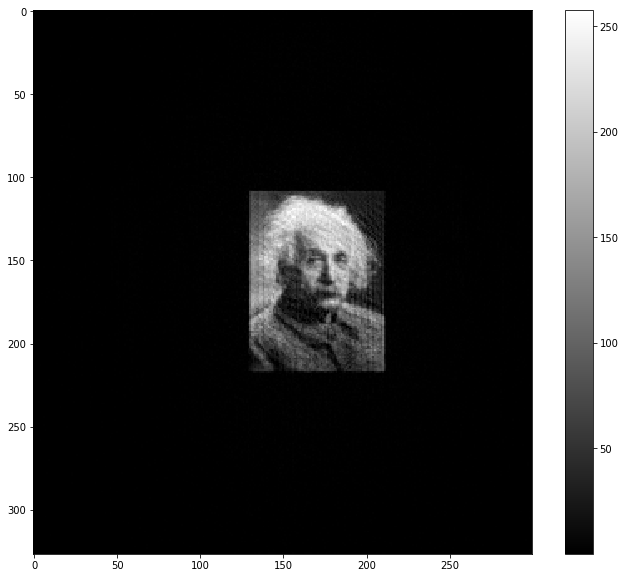

In [33]:
plt.figure(figsize=(12,10))

plt.imshow(np.abs(np.fft.fftshift(result['Reconstructed Density'])),cmap='gray')
plt.colorbar()
plt.show()

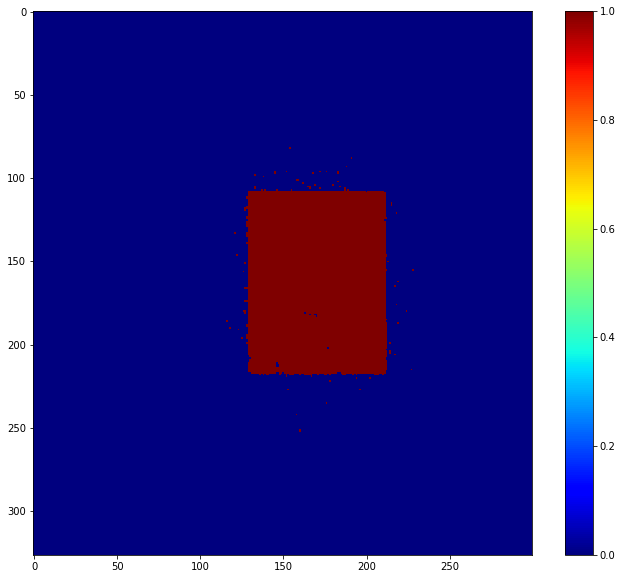

In [34]:
plt.figure(figsize=(12,10))

plt.imshow(np.fft.fftshift(np.abs(result['Final Support'])),cmap='jet')
plt.colorbar()
plt.show()